Starting VRP Performance Analysis

1. Loading summary data from: results/experiments/experiment_summary.csv
   Loaded 150 rows
   Algorithms found: nsga2, ntnsga2, aco, pso, ga
   Columns available: algorithm, run, seed, distance, cost, route_time, solving_time, clusters, epochs
   Available metrics for plotting: ['solving_time', 'route_time', 'distance', 'cost']

   Creating boxplot for: solving_time
      Saved to: figure_solving_time_boxplot.png


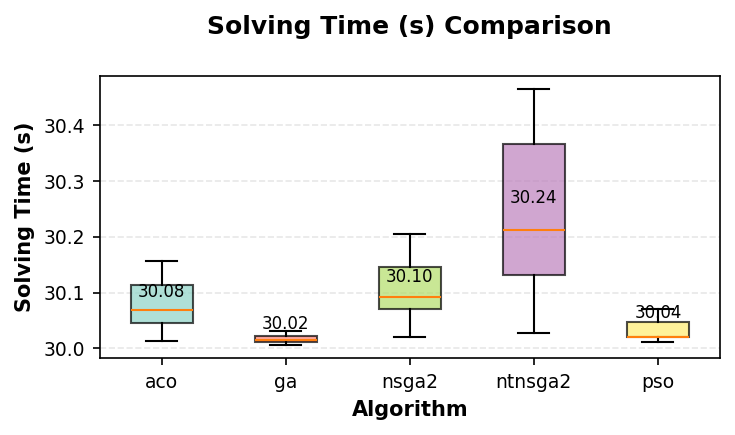


   Creating boxplot for: route_time
      Saved to: figure_route_time_boxplot.png


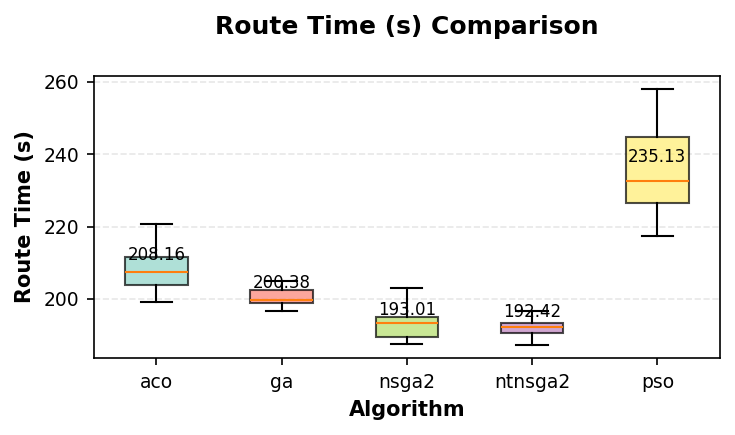


   Creating boxplot for: distance
      Saved to: figure_distance_boxplot.png


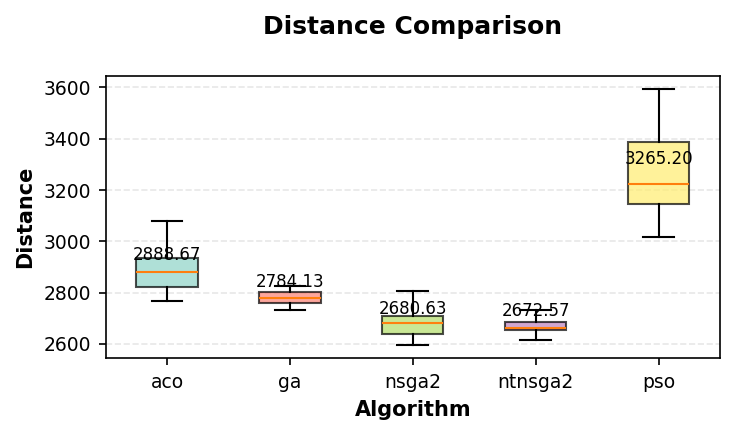


   Creating boxplot for: cost
      Saved to: figure_cost_boxplot.png


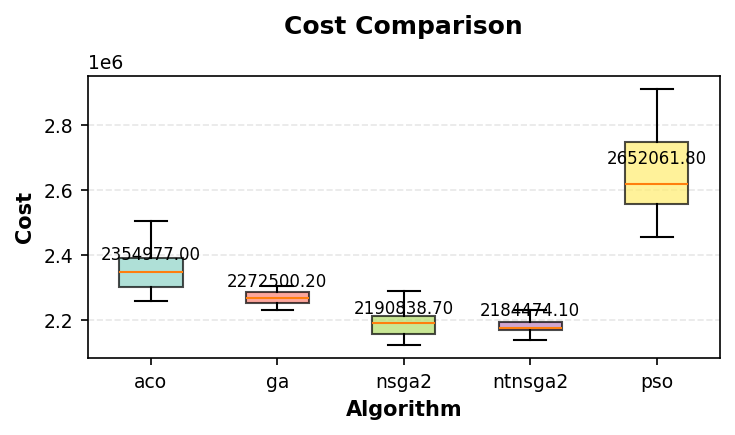


2. Analyzing convergence data from: results/experiments
Looking for data in: results/experiments
Found 152 items in directory
  Processing: ntnsga2_run1 -> Algorithm: ntnsga2
    Loaded 71 rows
  Processing: nsga2_run24 -> Algorithm: nsga2
    Loaded 152 rows
  Processing: ntnsga2_run19 -> Algorithm: ntnsga2
    Loaded 70 rows
  Processing: pso_run7 -> Algorithm: pso
    Loaded 146 rows
  Processing: ga_run24 -> Algorithm: ga
    Loaded 672 rows
  Processing: pso_run10 -> Algorithm: pso
    Loaded 145 rows
  Processing: pso_run4 -> Algorithm: pso
    Loaded 143 rows
  Processing: pso_run8 -> Algorithm: pso
    Loaded 147 rows
  Processing: pso_run23 -> Algorithm: pso
    Loaded 146 rows
  Processing: aco_run26 -> Algorithm: aco
    Loaded 194 rows
  Processing: nsga2_run15 -> Algorithm: nsga2
    Loaded 152 rows
  Processing: aco_run11 -> Algorithm: aco
    Loaded 191 rows
  Processing: aco_run1 -> Algorithm: aco
    Loaded 194 rows
  Processing: aco_run10 -> Algorithm: aco
    Loaded

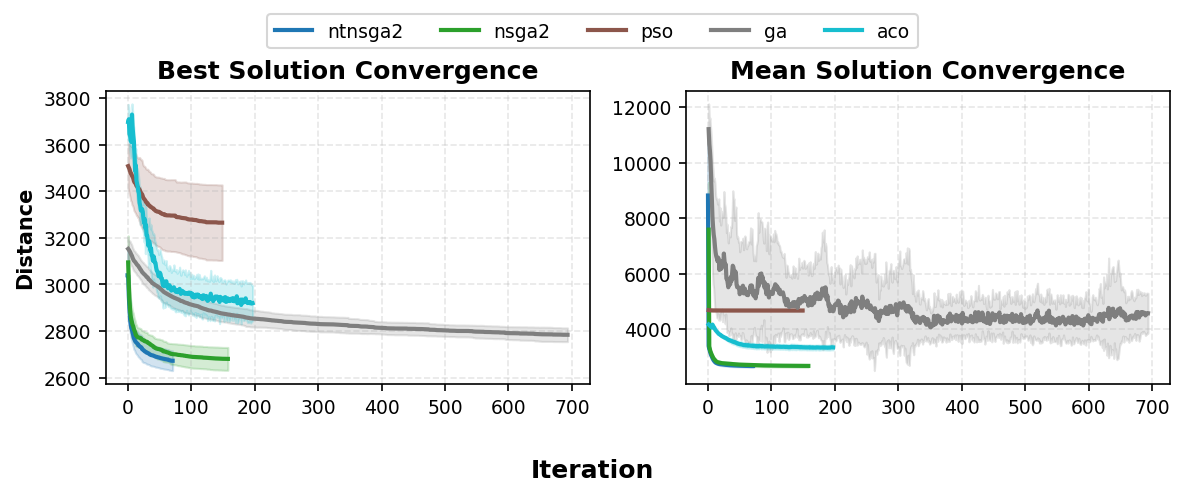


   Creating time convergence plot...
      Saved to: figure_convergence_time.png


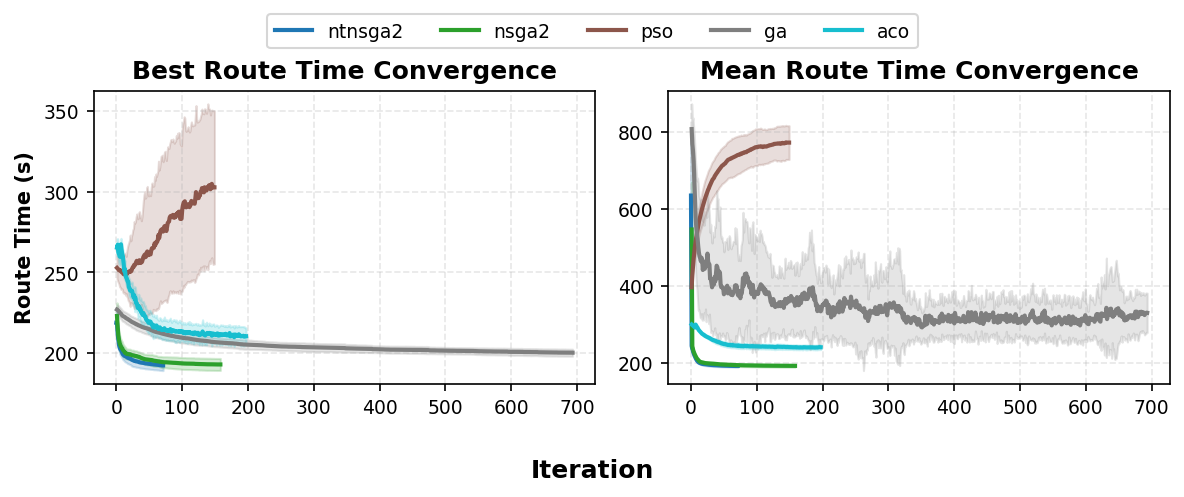


Analysis complete!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import warnings
from matplotlib.ticker import MaxNLocator
import os

warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

GLOBAL_PATH = Path("results/experiments")


class ConvergenceAnalyzer:
    def __init__(self, parent_dir: str):
        self.parent_dir = Path(parent_dir)
        self.data = {}
    
    def load_data(self):
        print(f"Looking for data in: {self.parent_dir}")
        if not self.parent_dir.exists():
            print(f"ERROR: Directory {self.parent_dir} does not exist!")
            return
        
        pattern = re.compile(r"^(.+?)_run(\d+)$")
        subdirs = list(self.parent_dir.iterdir())
        print(f"Found {len(subdirs)} items in directory")
        
        for subdir in subdirs:
            if not subdir.is_dir():
                continue
            
            match = pattern.match(subdir.name)
            if match:
                algo_name = match.group(1)
                print(f"  Processing: {subdir.name} -> Algorithm: {algo_name}")
                
                metrics_file = subdir / "metrics.csv"
                if not metrics_file.exists():
                    metrics_file = subdir / "cluster_0" / "metrics.csv"
                
                df = pd.read_csv(metrics_file)
                df = df.drop_duplicates(subset=['iter'], keep='last')
                df = df.sort_values('iter').reset_index(drop=True)
                if algo_name not in self.data:
                    self.data[algo_name] = []
                self.data[algo_name].append(df)
                print(f"    Loaded {len(df)} rows")
        
        print(f"\nTotal algorithms loaded: {len(self.data)}")
        for algo, runs in self.data.items():
            print(f"  {algo}: {len(runs)} runs")
    
    def get_convergence_data(self):
        results = {}
        for algo_name, runs in self.data.items():
            if not runs:
                continue
            algo_results = {}
            metrics_to_collect = ['best', 'mean', 'best_route_time', 'mean_route_time']
            
            for metric in metrics_to_collect:
                all_iterations = []
                all_values = []
                for df in runs:
                    if metric in df.columns:
                        all_iterations.append(df['iter'].values)
                        all_values.append(df[metric].values)
                
                if all_iterations:
                    min_iter = min([iters[0] for iters in all_iterations])
                    max_iter = max([iters[-1] for iters in all_iterations])
                    common_iters = np.arange(min_iter, max_iter + 1)
                    interpolated_values = []
                    
                    for iters, vals in zip(all_iterations, all_values):
                        if len(iters) > 1:
                            interp_vals = np.interp(common_iters, iters, vals)
                            interpolated_values.append(interp_vals)
                    
                    if interpolated_values:
                        mean_values = np.mean(interpolated_values, axis=0)
                        std_values = np.std(interpolated_values, axis=0)
                        algo_results[metric] = (common_iters, mean_values, std_values)
            
            if algo_results:
                results[algo_name] = algo_results
        
        print(f"\nConvergence data prepared for {len(results)} algorithms")
        for algo, metrics in results.items():
            print(f"  {algo}: {list(metrics.keys())}")
        
        return results


def prettify_label(label):
    label = label.replace('_', ' ').title()
    label = label.replace('Route Time', 'Route Time (s)')
    label = label.replace('Solving Time', 'Solving Time (s)')
    return label


def analyze_vrp_performance():
    print("=" * 60)
    print("Starting VRP Performance Analysis")
    print("=" * 60)
    
    summary_path = GLOBAL_PATH / 'experiment_summary.csv'
    if summary_path.exists():
        print(f"\n1. Loading summary data from: {summary_path}")
        df = pd.read_csv(summary_path)
        print(f"   Loaded {len(df)} rows")
        print(f"   Algorithms found: {', '.join(df['algorithm'].unique().tolist())}")
        print(f"   Columns available: {', '.join(df.columns.tolist())}")
        
        algorithms = sorted(df['algorithm'].unique())
        metrics = ['solving_time', 'route_time', 'distance', 'cost']
        available_metrics = [m for m in metrics if m in df.columns]
        print(f"   Available metrics for plotting: {available_metrics}")
        
        for metric in available_metrics:
            print(f"\n   Creating boxplot for: {metric}")
            fig, ax = plt.subplots(figsize=(5, 3))
            
            box_data = []
            algo_labels = []
            for algo in algorithms:
                values = df[df['algorithm'] == algo][metric].values
                if len(values) > 0:
                    box_data.append(values)
                    algo_labels.append(algo)
            
            if box_data:
                bp = ax.boxplot(
                    box_data,
                    patch_artist=True,
                    showmeans=False,
                    showfliers=False
                )
                
                colors = plt.cm.Set3(np.linspace(0, 1, len(box_data)))
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
                
                # labels slightly above the box border
                for i, data in enumerate(box_data):
                    mean_val = np.mean(data)
                    y_min, y_max = ax.get_ylim()
                    offset = 0.02 * (y_max - y_min)
                    ax.text(
                        i + 1,
                        mean_val + offset,
                        f'{mean_val:.2f}',
                        ha='center',
                        va='bottom',
                        fontsize=8,
                        color='black'
                    )
                
                ax.set_xlabel('Algorithm', fontweight='bold')
                ax.set_ylabel(prettify_label(metric), fontweight='bold')
                ax.set_title(
                    f'{prettify_label(metric)} Comparison',
                    fontweight='bold',
                    pad=20
                )
                
                max_name_len = max(len(str(algo)) for algo in algo_labels)
                rotation = 45 if max_name_len > 8 else 0
                ax.set_xticklabels(
                    algo_labels,
                    rotation=rotation,
                    ha='right' if rotation else 'center'
                )
                
                ax.grid(True, alpha=0.3, axis='y', linestyle='--')
                plt.tight_layout()
                
                save_path = f'figure_{metric}_boxplot.png'
                plt.savefig(save_path, bbox_inches='tight', dpi=150)
                print(f"      Saved to: {save_path}")
                plt.show()
    
    print(f"\n2. Analyzing convergence data from: {GLOBAL_PATH}")
    analyzer = ConvergenceAnalyzer(GLOBAL_PATH)
    analyzer.load_data()
    
    if analyzer.data:
        print(f"\n   Creating convergence plots...")
        convergence_data = analyzer.get_convergence_data()
        algorithm_names = list(convergence_data.keys())
        
        print(f"   Algorithms with convergence data: {algorithm_names}")
        
        metric_groups = {
            "distance": ["best", "mean"],
            "time": ["best_route_time", "mean_route_time"]
        }
        
        for metric_group, metrics_list in metric_groups.items():
            print(f"\n   Creating {metric_group} convergence plot...")
            
            available_metrics = []
            for sub_metric in metrics_list:
                for algo_data in convergence_data.values():
                    if sub_metric in algo_data:
                        available_metrics.append(sub_metric)
                        break
            
            if not available_metrics:
                print(f"      No {metric_group} metrics available")
                continue
            
            fig, axes = plt.subplots(
                1,
                len(available_metrics),
                figsize=(4 * len(available_metrics), 3),
                sharex=True,
                sharey=False
            )
            if len(available_metrics) == 1:
                axes = [axes]
            
            colors = plt.cm.tab10(np.linspace(0, 1, len(algorithm_names)))
            handles = []
            labels = []
            
            for idx, sub_metric in enumerate(available_metrics):
                ax = axes[idx]
                
                for algo_idx, (algo_name, algo_data) in enumerate(convergence_data.items()):
                    if sub_metric in algo_data:
                        iterations, mean_vals, std_vals = algo_data[sub_metric]
                        color = colors[algo_idx % len(colors)]
                        
                        line, = ax.plot(
                            iterations,
                            mean_vals,
                            label=algo_name,
                            color=color,
                            linewidth=2
                        )
                        
                        if idx == 0:
                            handles.append(line)
                            labels.append(algo_name)
                        
                        if len(std_vals) > 0 and np.any(std_vals > 0):
                            ax.fill_between(
                                iterations,
                                mean_vals - std_vals,
                                mean_vals + std_vals,
                                color=color,
                                alpha=0.2
                            )
                
                title_map = {
                    "best": "Best Solution Convergence",
                    "mean": "Mean Solution Convergence",
                    "best_route_time": "Best Route Time Convergence",
                    "mean_route_time": "Mean Route Time Convergence"
                }
                
                ylabel_map = {
                    "best": "Distance",
                    "mean": "Distance",
                    "best_route_time": "Route Time (s)",
                    "mean_route_time": "Route Time (s)"
                }
                
                ax.set_title(title_map.get(sub_metric, sub_metric), fontweight='bold')
                ax.grid(True, alpha=0.3, linestyle='--')
            
            axes[0].set_ylabel(
                ylabel_map.get(available_metrics[0], available_metrics[0]),
                fontweight='bold'
            )
            fig.supxlabel('Iteration', fontweight='bold')
            
            fig.legend(
                handles,
                labels,
                loc='upper center',
                bbox_to_anchor=(0.5, 1.07),
                ncol=len(labels),
                frameon=True
            )
            
            plt.tight_layout()
            save_path = f'figure_convergence_{metric_group}.png'
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            print(f"      Saved to: {save_path}")
            plt.show()
    else:
        print("   No convergence data loaded!")
    
    print("\n" + "=" * 60)
    print("Analysis complete!")
    print("=" * 60)


if __name__ == "__main__":
    os.makedirs('figures', exist_ok=True)
    analyze_vrp_performance()
